In [1]:
import os; import pandas as pd; import numpy  as np
from pandas.tseries.offsets import *
import statsmodels.formula.api as smf
from glob import glob
from datetime import datetime
import matplotlib.pyplot as plt

import tensorflow
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from IPython.display import IFrame
def swish(x): return (K.sigmoid(x) * x)

import seaborn as sns
sns.set(style='white', font_scale=1.3, rc={
    'lines.linewidth': 4,
    'axes.grid': True, 'grid.linestyle': ':',
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.right': True,
    'axes.spines.top': True,
    'axes.edgecolor': '.5',
})
# load packages
import pandas as pd
import pickle
import numpy as np
import keras
from keras import backend as K
from keras.models import load_model, Model
from keras.layers import Flatten, Dense, Dropout, Activation, Input, LSTM, Reshape, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras import Input, layers
from keras.layers import LeakyReLU
#from keras.layers.advanced_activations import LeakyReLU
from keras.utils import np_utils

from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# set random seeds
np.random.seed(1)
tensorflow.random.set_seed(2)
# Set the Random Seed
import random


seed_value = 2020

os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tensorflow.random.set_seed(seed_value)

session_conf = tensorflow.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tensorflow.compat.v1.Session(graph=tensorflow.compat.v1.get_default_graph(), config=session_conf)
tensorflow.compat.v1.keras.backend.set_session(sess)
from keras.utils import np_utils


In [2]:
#utils functions
def midPrice(lob_data):
    a=lob_data['AP1'].values.tolist()
    b=lob_data['BP1'].values.tolist()
    m=np.zeros(len(a))
    for i in range(len(a)):
        m[i]=(a[i]+b[i])/2
    return m
def upDown(m):
    u_d=np.zeros(len(a))
    for i in range(1,len(a)):
        if m[i-1]>m[i]:#scende il prezzo
            u_d[i-1]=-1
        elif m[i-1]<m[i]:#sale il prezzo
            u_d[i-1]=1
        else:
            u_d[i-1]=0
    return u_d

def ret(m):
    r=np.zeros(len(m))
    for i in range(1,len(m)):
        r[i]=m[i-1]-m[i]
    return r

def deltaT(m):
    N=0
    d=np.zeros(len(m))
    for i in range(1,len(m)):
        d[i]=m[i-1]-m[i]
        if [i]!=0:
            N+=1
    return int((2.34*10**7)/N)

def doHk(deltT,k):
    hk=np.zeros(k)
    for i in range(k):
        hk[i]=np.int16((1/5)*i*deltT)
    return hk

def retHk(m,hk):
    ret=np.zeros(100)
    for i,k in zip(range(len(m)),hk):
        ret[i]=m[i+k]-m[i]
    return ret

def OF_1(ld):
    of=np.zeros((len(ld),6))
    for i,ii in zip(range(1,12,2),range(0,6,2)): #giro sui prezzi ask e volumi ask di conseguenza
        for j in range(1,len(ld)): #giro sulle righe
            #ask
            if ld[j][i-1]>ld[j-1][i-1]: #p_t>p_t-1
                of[j-1][ii]=-1*ld[j][i]
            elif ld[j][i-1]<ld[j-1][i-1]: #p_t<p_t-1
                of[j-1][ii]=ld[j][i]
            elif ld[j][i-1]==ld[j-1][i-1]: #p_t=p_t-1
                of[j-1][ii]=ld[j][i]-ld[j-1][i]
    for w,ww in zip(range(3,12,4),range(1,7,2)):
        for jj in range(1,len(ld)):    
            #bid
            if ld[jj][w-1]>ld[jj-1][w-1]: #p_t>p_t-1
                of[jj-1][ww]=ld[jj][w]
            elif ld[jj][w-1]<ld[jj-1][w-1]: #p_t<p_t-1
                of[jj-1][ww]=-1*ld[jj][w]
            elif ld[jj][w-1]==ld[jj-1][w-1]: #p_t=p_t-1
                of[jj-1][ww]=ld[jj][w]-ld[jj-1][w]
    return of

In [3]:
lob_data=pd.read_csv('/Users/macri/Desktop/out_1.csv')#legge il LOB
lob_data.reset_index(drop=True,inplace=True)
lob_data.drop(['index'], axis=1,inplace=True)
C= int(len(lob_data)*0.1) #per ragioni di spazio/efficienza nei test ne prende solo il 10%
b=lob_data.iloc[ :C].copy()
ld=b.values.tolist()
lob_data=b
b

,AP1,AV1,BP1,BV1,AP2,AV2,BP2,BV2,AP3,AV3,BP3,BV3
0,90.48,4315,90.44,374,90.52,100,90.40,50,90.53,1730,90.35,100
1,90.48,4004,90.44,374,90.52,100,90.40,50,90.53,1730,90.35,100
2,90.48,4004,90.44,374,90.52,100,90.40,50,90.53,1730,90.35,100
3,90.48,4004,90.44,374,90.52,100,90.40,50,90.53,1730,90.35,100
4,90.48,4004,90.44,374,90.52,100,90.40,50,90.53,2825,90.35,100
...,...,...,...,...,...,...,...,...,...,...,...,...
104852,89.56,137,89.53,434,89.57,105,89.52,234,89.58,137,89.51,344
104853,89.56,126,89.54,244,89.57,105,89.53,334,89.58,137,89.52,234
104854,89.56,105,89.54,244,89.57,105,89.53,334,89.58,137,89.52,234
104855,89.56,5,89.54,244,89.57,105,89.53,334,89.58,137,89.52,234


In [4]:
ld=lob_data.values.tolist()
aa=OF_1(ld) #fa Order Flow
bCols=np.ravel([['aOF_%d'%level, 'bOF_%d'%level] for level in [1,2,3]])
of_data=pd.DataFrame(aa, columns=bCols)
of_data

,aOF_1,bOF_1,aOF_2,bOF_2,aOF_3,bOF_3
0,-311.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,-100.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
104852,-11.0,244.0,-244.0,334.0,0.0,234.0
104853,-21.0,0.0,0.0,0.0,0.0,0.0
104854,-100.0,0.0,0.0,0.0,0.0,0.0
104855,-105.0,0.0,0.0,0.0,-137.0,0.0


In [5]:
m=pd.DataFrame(midPrice(lob_data),columns=['m'])#.pct_change()
m['d']=m['m'].diff()
#m.dropna(inplace=True)
of_data['d']=m['m'].pct_change()
of_data.dropna(inplace=True)

<AxesSubplot:>

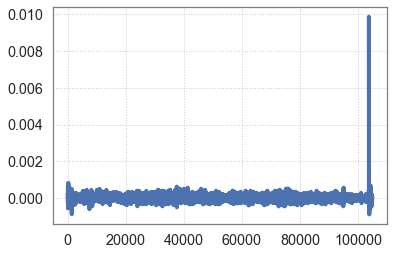

In [6]:
of_data['d'].plot()

array([[<AxesSubplot:title={'center':'aOF_1'}>,
        <AxesSubplot:title={'center':'bOF_1'}>,
        <AxesSubplot:title={'center':'aOF_2'}>],
       [<AxesSubplot:title={'center':'bOF_2'}>,
        <AxesSubplot:title={'center':'aOF_3'}>,
        <AxesSubplot:title={'center':'bOF_3'}>],
       [<AxesSubplot:title={'center':'d'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

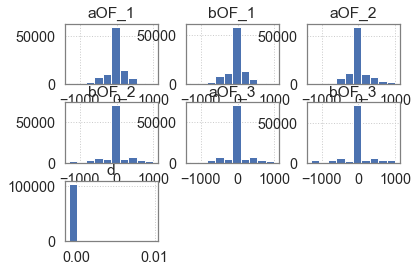

In [7]:
x = of_data
UPPERBOUND, LOWERBOUND = np.percentile(x, [1,99])
y = np.clip(x, UPPERBOUND, LOWERBOUND)
pd.DataFrame(y).hist()

array([[<AxesSubplot:title={'center':'bOF1'}>,
        <AxesSubplot:title={'center':'aOF1'}>,
        <AxesSubplot:title={'center':'bOF2'}>],
       [<AxesSubplot:title={'center':'aOF2'}>,
        <AxesSubplot:title={'center':'bOF3'}>,
        <AxesSubplot:title={'center':'aOF3'}>],
       [<AxesSubplot:title={'center':'r'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

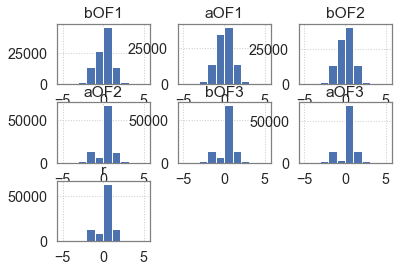

In [8]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer 
normalizer = QuantileTransformer(output_distribution='normal')
scaled = normalizer.fit_transform(x)
oflo=pd.DataFrame(scaled,columns=['bOF1','aOF1','bOF2','aOF2','bOF3','aOF3','r'])
oflo.hist()

In [9]:
norm=QuantileTransformer(output_distribution='normal')
sc = norm.fit_transform(of_data['d'].values.reshape(-1,1))

In [10]:
def format_data(data, lag=100, dimension=6):
    data = data.values
    shape = data.shape
    X = np.zeros((shape[0]-lag, lag, dimension))
    Y = np.zeros((shape[0]-lag, 1)) # 1 for the number of forecasting horizons
    for i in range(shape[0]-lag):
        X[i] = data[i:i+lag, :dimension] # take the variables' columns as features x
        Y[i] = data[i+lag-1, -1:] # take the last column as y
    X = X.reshape(X.shape[0], lag, dimension, 1)
    Y = Y.reshape(Y.shape[0],1)
    return X,Y

In [11]:
data=format_data(oflo)
X,Y=data
n_hiddens=64
V = int(len(oflo)*0.1)
Z = int(len(oflo)*0.4)
trainX_CNN, trainY_CNN = X[:V], Y[:V]
valX_CNN, valY_CNN     = X[V:Z], Y[V:Z]
testX_CNN,testY_CNN    = X[Z:], Y[Z:]
print(trainX_CNN.shape, trainY_CNN.shape)
print(valX_CNN.shape, valY_CNN.shape)
print(testX_CNN.shape, testY_CNN.shape)

(10485, 100, 6, 1) (10485, 1)
(31457, 100, 6, 1) (31457, 1)
(62814, 100, 6, 1) (62814, 1)


In [12]:
def create_nn(T, NF,number_of_lstm):

    input_lmd = tensorflow.keras.Input(shape=(T, NF, 1))

    conv_first1 = Conv2D(32, kernel_size=(1, 2), strides=(1, 2))(input_lmd)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    #
    layer_x = layers.Conv2D(filters=32, kernel_size=(10,1),strides=(1,10), padding='same')(conv_first1)
    layer_x = layers.LeakyReLU(alpha=0.01)(layer_x)
    # inception
    convsecond_1 = Conv2D(64, (1, 1), padding='same', strides=(1,1))(layer_x)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)
    convsecond_1 = Conv2D(64, (3, 1), padding='same', strides=(1,1))(convsecond_1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)

    convsecond_2 = Conv2D(64, (1, 1), padding='same', strides=(1,1))(layer_x)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)
    convsecond_2 = Conv2D(64, (5, 1), padding='same', strides=(1,1))(convsecond_2)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)

    convsecond_3 = MaxPooling2D((3, 1), strides=(1, 1), padding='same')(layer_x)
    convsecond_3 = Conv2D(64, (1, 1), padding='same', strides=(1,1))(convsecond_3)
    convsecond_3 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_3)
    
    convsecond_output = keras.layers.concatenate([convsecond_1, convsecond_2, convsecond_3], axis=3)
    conv_reshape = Reshape((int(convsecond_output.shape[1]), int(convsecond_output.shape[3])))(convsecond_output)
    conv_reshape = keras.layers.Dropout(0.3, noise_shape=(None, 1, int(conv_reshape.shape[2])))(conv_reshape, training=True)

    #  LSTM layer
    conv_lstm = LSTM(number_of_lstm)(conv_reshape)

    # output layer
    out = Dense(1, activation='leaky_relu')(conv_lstm)
    model = Model(inputs=input_lmd, outputs=out)
    adam = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=adam, loss='mse')#, metrics=['accuracy']

    return model
  
deeplob = create_nn(trainX_CNN.shape[1], trainX_CNN.shape[2],n_hiddens)

deeplob.summary()
checkpoint_filepath = './model_tensorflow2/weights'


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 6, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 100, 3, 32)   96          ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 100, 3, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 100, 3, 32)   4128        ['leaky_re_lu[0][0]']            
                                                                                              

In [13]:
r=deeplob.fit(trainX_CNN, trainY_CNN, validation_data=(valX_CNN, valY_CNN), 
            epochs=50, batch_size=256)

Epoch 1/50
41/41 [==============================] - 22s 515ms/step - loss: 0.7403 - val_loss: 0.7129
Epoch 2/50
41/41 [==============================] - 20s 496ms/step - loss: 0.6644 - val_loss: 0.6183
Epoch 3/50
41/41 [==============================] - 20s 494ms/step - loss: 0.5850 - val_loss: 0.5344
Epoch 4/50
41/41 [==============================] - 20s 495ms/step - loss: 0.5093 - val_loss: 0.4620
Epoch 5/50
41/41 [==============================] - 21s 512ms/step - loss: 0.4437 - val_loss: 0.4026
Epoch 6/50
41/41 [==============================] - 20s 505ms/step - loss: 0.3961 - val_loss: 0.3636
Epoch 7/50
41/41 [==============================] - 20s 506ms/step - loss: 0.3578 - val_loss: 0.3273
Epoch 8/50
41/41 [==============================] - 20s 505ms/step - loss: 0.3283 - val_loss: 0.3016
Epoch 9/50
41/41 [==============================] - 27s 663ms/step - loss: 0.3096 - val_loss: 0.2870
Epoch 10/50
41/41 [==============================] - 30s 735ms/step - loss: 0.2987 - val_lo

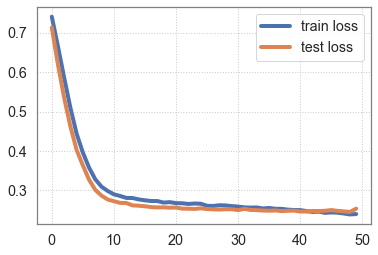

In [14]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [15]:
pred = deeplob.predict(trainX_CNN)

328/328 [==============================] - 5s 14ms/step


In [16]:
Ptrain = deeplob.predict(trainX_CNN)
Ptest =  deeplob.predict(testX_CNN)
Ptrain.shape, Ptest.shape

1963/1963 [==============================] - 28s 14ms/step


((10485, 1), (62814, 1))

In [17]:
pTrain=norm.inverse_transform(Ptrain)
pTest=norm.inverse_transform(Ptest)

In [18]:
from sklearn.metrics import mean_squared_error as mse
a=[11,22, 44,  89, 133, 178, 223, 267, 312, 356, 401,446]
rQuad=np.zeros(len(a))
for i,j in zip(range(len(a)),a):
    #for j in a:
    rQuad[i]=1-(mse(testY_CNN[:j,0],Ptest[:j])/mse(trainY_CNN[:j,0],Ptrain[:j]))
rQuad

array([0.65812374, 0.71700678, 0.7338423 , 0.7798209 , 0.74658873,
       0.70900804, 0.66544445, 0.60626783, 0.57182015, 0.55291671,
       0.5704794 , 0.55287833])

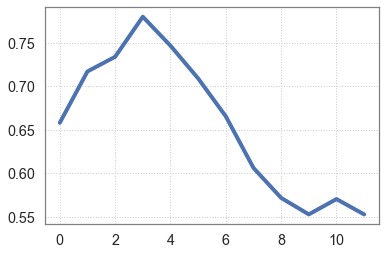

In [19]:
plt.plot(rQuad)
plt.show()

In [29]:
xx=[11,22, 44,  89, 133, 178, 223, 267, 312, 356, 401,446]
pred_test=np.zeros(len(xx))
pred_train=np.zeros(len(xx))
for i,j in zip(xx,range(len(pred))):
    pred_test[j]=pTest[i]
    pred_train[j]=pTrain[i]
pred_test,pred_train

(array([ 0.00000000e+00,  5.67025709e-05, -5.53822720e-05,  0.00000000e+00,
         0.00000000e+00, -5.66844974e-05,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00]),
 array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -5.65687333e-05,  5.59615146e-05, -5.51728554e-05,
        -5.62660935e-05,  0.00000000e+00,  5.65962728e-05,  0.00000000e+00]))

In [39]:
pdz=pd.DataFrame(pred_train+pred_test).diff(-1).fillna(0).apply(lambda x: x*100)

In [40]:
pdz

,0
0,-0.005670
1,0.011208
2,-0.005538
3,0.000000
4,0.011325
5,-0.016921
6,0.011113
7,0.000109
8,-0.005627
9,-0.005660


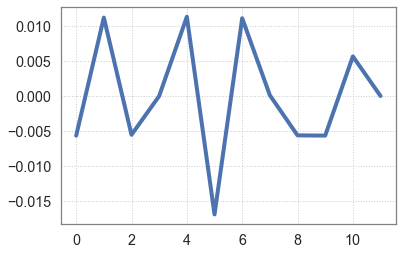

In [41]:
plt.plot(pdz)
plt.show()

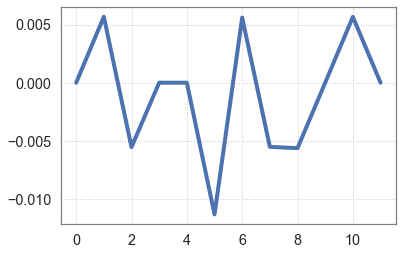

In [26]:
plt.plot(pred_train+pred_test)
plt.show()